In [1]:
%matplotlib inline

from models import Trial
from server import app
import numpy as np
import matplotlib.pyplot as plt
import data_analysis as da

# Setup
## Select Trial

In [2]:
# List Trial Ids
with app.app_context():
    trials = Trial.query.all()
    for trial in trials:
        print(trial)

6 - caleb - Test - 2018-07-08 17:34:22.104928
11 - caleb - initial trial with wrist device - 2018-07-16 17:47:20.754614
12 - caleb - disconnected (not attached to user) - 2018-07-16 17:52:07.986990
13 - caleb - device trial full - 2018-07-19 15:28:35.011461


In [3]:
# Set a trial ID here and continue running
# trial_id = int(input())
trial_id = 13

## Load Dataframes

In [4]:
with app.app_context():
    trial = Trial.query.get(trial_id)
    print("Loading Trial: " + str(trial))
    df_wrist = trial.df_wrist
    df_reflective = trial.df_reflective
    df_transitive = trial.df_transitive
print("\ndf_wrist")
print("columns: " + str(df_wrist.columns.tolist()))
print("shape  : " + str(df_wrist.shape))
print("\ndf_reflective")
print("columns: " + str(df_reflective.columns.tolist()))
print("shape  : " + str(df_reflective.shape))
print("\ndf_transitive")
print("columns: " + str(df_transitive.columns.tolist()))
print("shape  : " + str(df_transitive.shape))

Loading Trial: 13 - caleb - device trial full - 2018-07-19 15:28:35.011461



df_wrist
columns: ['red', 'ir', 'oxygen', 'hr', 'ratio', 'correlation', 'gyro_x', 'gyro_y', 'gyro_z', 'accel_x', 'accel_y', 'accel_z']
shape  : (6354, 12)

df_reflective
columns: ['red', 'ir', 'oxygen', 'hr', 'ratio', 'correlation']
shape  : (6341, 6)

df_transitive
columns: ['oxygen', 'hr']
shape  : (12743, 2)


#### Device Types And Column Information
* `df_wrist` - Wrist Worn Device (MAX30102 on Wrist with MPU9250 Motion Sensor)
  * Instantaneous Data points
    * `red` - red LED reflected radiance
    * `ir` - infrared LED reflected radiance
    * `gyro_x` - rotation in the x direction.
    * `gyro_y` - rotation in the y direction.
    * `gyro_z` - rotation in the z direction.
    * `accel_x` - acceleration in the x direction.
    * `accel_y` - acceleration in the y direction.
    * `accel_z` - acceleration in the z direction.
  * Calculated data based on last 100 `red` and `ir` LED points
    * `oxygen` - oxygen saturation, or NaN if invalid
    * `hr` - heart-rate, or NaN if invalid
    * `ratio` - calculated SpO2 ratio
    * `correlation` - calculated pearson correlation
* `df_reflective` - Fingertip Reflective Sensor (MAX30102 on Fingertip)
  * Instantaneous Data points
    * `red` - red LED reflected radiance
    * `ir` - infrared LED reflected radiance
  * Calculated data based on last 100 `red` and `ir` LED points
    * `oxygen` - oxygen saturation, or NaN if invalid
    * `hr` - heart-rate, or NaN if invalid
    * `ratio` - calculated SpO2 ratio
    * `correlation` - calculated pearson correlation
* `df_transitive` - Fingetip Transitive Sensor (Berry Medical Fingertip Device)
  * `oxygen` - oxygen saturation, or NaN if invalid
  * `hr` - heart-rate, or NaN if invalid

# Experiments

## 1. Predict df_transitive oxygen based on df_wrist led traces.

### a. Align dataframes to common timestamps

In [5]:
from data_analysis import normalize_timestamps
df_wrist_norm, df_transitive_norm = normalize_timestamps(df_wrist, df_transitive)

### b. Prepare Train and Test Data

In [6]:
train_ratio = 0.66

X = df_wrist_norm[['red', 'ir']].values
y = df_transitive_norm[['oxygen']].values

data_count = X.shape[0]

y = y.reshape((data_count,))

da.print_label_counts(y)

train_size = int(data_count * train_ratio)

# Split data before windowizing
X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[:train_size]

# Windowize data and corresponding label
X_train, y_train = da.windowize_data(X_train, y_train)
X_test, y_test = da.windowize_data(X_test, y_test)

Label: 98, Count: 4987
Label: 97, Count: 500
Label: 99, Count: 850


### c. Run Random Forest

Accuracy: 0.33122568093385213


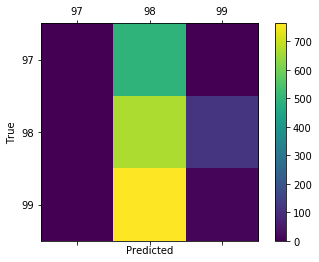

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_predicted = clf.predict(X_test)
da.analyze_results(y_test, y_predicted)

## 2. Predict Reliability based on LED and motion traces

In [8]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

Using TensorFlow backend.


In [1]:
# Wrist dataframe columns to be used
input_columns = ['red', 'ir', 'gyro_x', 'gyro_y', 'gyro_z', 'accel_x', 'accel_y', 'accel_z']

X = df_wrist[input_columns]
y = df_wrist[['oxygen']].values

y = y.reshape(y.shape[0],)

y = np.invert(np.isnan(y))


da.print_label_counts(y)


NameError: name 'df_wrist' is not defined